# IV. Проверка гипотез и статистический анализ

**Цель:** проверить статистическую значимость гипотез, выдвинутых в EDA и подготовленных в SQL-ноутбуке; загрузить подготовленные датасеты (`data/analysis_ready/`), проверить допущения, выполнить тесты (t-test / ANOVA / regression), оценить размер эффекта и дать продуктовые выводы.

---
## 1. Импорт библиотек и загрузка данных
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

sns.set_theme(style="darkgrid", palette="deep")

data_directory = '../data/analysis_ready'
df_h1 = pd.read_parquet(f'{data_directory}/h1_price_by_gender.parquet')
df_h2 = pd.read_parquet(f'{data_directory}/h2_daily_counts_by_weekday.parquet')
df_h3 = pd.read_parquet(f'{data_directory}/h3_duration_by_gender.parquet')
df_h4 = pd.read_parquet(f'{data_directory}/h4_age_price_by_user.parquet')

print(df_h1.shape, df_h2.shape, df_h3.shape, df_h4.shape)


(57597, 4) (184, 3) (57597, 4) (58033, 5)


---
## 2. Функция для расчёта размера эффекта
---

In [2]:
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_sd = np.sqrt(((nx-1)*x.std(ddof=1)**2 + (ny-1)*y.std(ddof=1)**2) / dof)
    return (x.mean() - y.mean()) / pooled_sd

---
## 3. Статистическая проверка гипотез
---

- Для гипотез H1 и H3 мы работаем с агрегатами *по пользователю* (avg per user) — это даёт независимые наблюдения (один ряд = один пользователь). Так как мы агрегируем по гендеру, то исключаем значения U (unknown).

- Для H2 используем *агрегаты по дню* (один ряд = одна дата).

- Для H4 используем per-user среднюю цену и возраст пользователя (используются даже те записи, где пол указан как неизвестный).

**Гипотеза 1: H1 — Средняя стоимость поездки различается между мужчинами и женщинами.**

In [3]:
display(df_h1.groupby('gender_cd')['avg_price_per_user'].describe())

,count,mean,std,min,25%,50%,75%,max
gender_cd,,,,,,,,
F,10762.0,176.105603,118.297064,12.98,105.4625,139.755,203.780,1188.80
M,46835.0,152.486758,99.142282,5.30,97.1900,124.690,171.085,1329.36


In [4]:
# Проверим равенство дисперсий
levene = stats.levene(df_h1.loc[df_h1['gender_cd']=='M','avg_price_per_user'],
                      df_h1.loc[df_h1['gender_cd']=='F','avg_price_per_user'])
print(f"Levene p: {levene.pvalue:.3e}")

# Welch's t-test
t_stat, p_val = stats.ttest_ind(
    df_h1.loc[df_h1['gender_cd']=='M','avg_price_per_user'],
    df_h1.loc[df_h1['gender_cd']=='F','avg_price_per_user'],
    equal_var=False
)
print(f"t: {t_stat:.3f}, p: {p_val:.3e}")

# Размер эффекта
mean_diff = (df_h1[df_h1['gender_cd']=='M']['avg_price_per_user'].mean()
            - df_h1[df_h1['gender_cd']=='F']['avg_price_per_user'].mean())
pooled_std = np.sqrt(
    (df_h1[df_h1['gender_cd']=='M']['avg_price_per_user'].std()**2 +
     df_h1[df_h1['gender_cd']=='F']['avg_price_per_user'].std()**2)/2)
cohens_d = mean_diff / pooled_std
print(f"Cohen's d: {abs(cohens_d):.3f}")

Levene p: 2.187e-58
t: -19.219, p: 2.634e-81
Cohen's d: 0.216


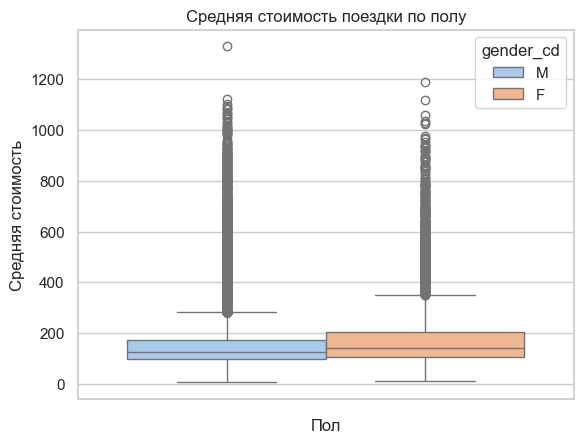

In [5]:
sns.boxplot(data=df_h1, hue='gender_cd', y='avg_price_per_user', palette='pastel')
plt.title('Средняя стоимость поездки по полу')
plt.xlabel('Пол')
plt.ylabel('Средняя стоимость')
plt.show()

Проверка гипотезы H1 показала статистически значимые различия в средней стоимости поездки между мужчинами и женщинами (p-value = 2.634e-81, p < 0.05). Женщины совершают более дорогие поездки, однако сила эффекта невелика (Cohen’s d = 0.216), что указывает на небольшое практическое влияние.

Тарифы можно оставлять едиными, пол не влияет на выручку.

**Гипотеза 2: H2 — Активность пользователей зависит от дня недели.**

In [6]:
display(df_h2.groupby('dow')['rides_per_day'].describe())

,count,mean,std,min,25%,50%,75%,max
dow,,,,,,,,
0,26.0,1649.000000,1059.953056,5.0,828.75,1855.5,2299.50,3431.0
1,27.0,1830.111111,1253.899773,2.0,651.50,2203.0,2766.00,3750.0
2,26.0,1980.692308,1324.369065,1.0,741.50,2426.0,2836.00,3963.0
3,27.0,1973.111111,1363.879487,1.0,563.00,2409.0,2914.50,4036.0
4,26.0,2070.346154,1350.519572,4.0,871.00,2409.5,3169.25,4036.0
5,26.0,2163.230769,1374.104896,5.0,1047.50,2357.0,3171.50,4382.0
6,26.0,1865.576923,1197.823198,4.0,894.00,2122.5,2502.50,3790.0


0 - Воскресенье, 6 - Суббота

In [7]:
# Проверим равенство дисперсий
levene = stats.levene(*[g['rides_per_day'].values for _, g in df_h2.groupby('dow')])
print(f"Levene p: {levene.pvalue:.3f}")

# ANOVA
anova = stats.f_oneway(*[g['rides_per_day'].values for _, g in df_h2.groupby('dow')])
print(f"ANOVA F: {anova.statistic:.3f}, p: {anova.pvalue:.3f}")

# Kruskal
kruskal = stats.kruskal(*[g['rides_per_day'].values for _, g in df_h2.groupby('dow')])
print(f"Kruskal p: {kruskal.pvalue:.3f}")

Levene p: 0.813
ANOVA F: 0.455, p: 0.841
Kruskal p: 0.743


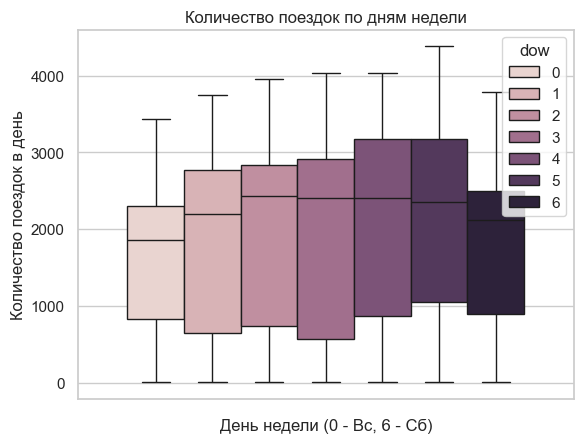

In [8]:
sns.boxplot(data=df_h2, hue='dow', y='rides_per_day')
plt.title('Количество поездок по дням недели')
plt.xlabel('День недели (0 - Вс, 6 - Сб)')
plt.ylabel('Количество поездок в день')
plt.show()

Во всех тестах p-value > 0.05, что говорит о том, что количество поездок не зависит от дня недели. Небольшие колебания (например, больше поездок в пятницу) — естественные, не статистически значимые.

Планирование самокатов можно вести равномерно по неделе.

**Гипотеза 3: H3 — Средняя длительность поездки различается между мужчинами и женщинами.**

In [9]:
display(df_h3.groupby('gender_cd')['avg_trip_duration_min'].describe())

,count,mean,std,min,25%,50%,75%,max
gender_cd,,,,,,,,
F,10762.0,17.713998,15.537045,1.12,8.1225,12.62,21.54,119.51
M,46835.0,14.714258,13.028164,0.81,7.1200,10.79,17.28,119.84


In [10]:
# Проверим равенство дисперсий
levene = stats.levene(df_h3.loc[df_h3['gender_cd']=='M','avg_trip_duration_min'],
                      df_h3.loc[df_h3['gender_cd']=='F','avg_trip_duration_min'])
print(f"Levene p: {levene.pvalue:.3e}")

# Welch's t-test
t_stat, p_val = stats.ttest_ind(
    df_h3.loc[df_h3['gender_cd']=='M','avg_trip_duration_min'],
    df_h3.loc[df_h3['gender_cd']=='F','avg_trip_duration_min'],
    equal_var=False
)
print(f"t: {t_stat:.3f}, p: {p_val:.3e}")

# Размер эффекта
mean_diff = (df_h3[df_h3['gender_cd']=='M']['avg_trip_duration_min'].mean()
            - df_h3[df_h3['gender_cd']=='F']['avg_trip_duration_min'].mean())
pooled_std = np.sqrt(
    (df_h3[df_h3['gender_cd']=='M']['avg_trip_duration_min'].std()**2 +
     df_h3[df_h3['gender_cd']=='F']['avg_trip_duration_min'].std()**2)/2)
cohens_d = mean_diff / pooled_std
print(f"Cohen's d: {abs(cohens_d):.3f}")

Levene p: 4.670e-58
t: -18.584, p: 3.347e-76
Cohen's d: 0.209


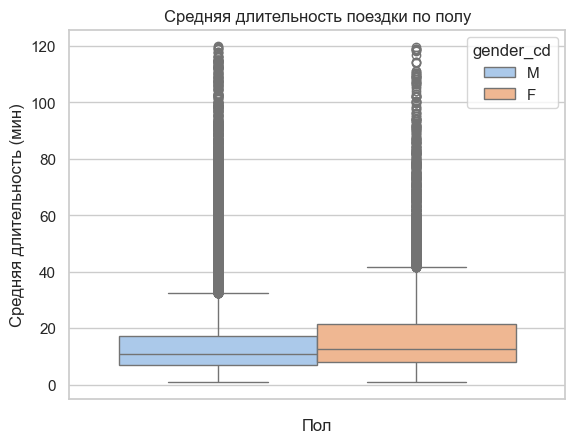

In [11]:
sns.boxplot(data=df_h3, hue='gender_cd', y='avg_trip_duration_min', palette='pastel')
plt.title('Средняя длительность поездки по полу')
plt.xlabel('Пол')
plt.ylabel('Средняя длительность (мин)')
plt.show()

Дисперсии не равны (p-value = 4.670e-58, p < 0.05). Различия значимы (p-value = 3.347e-76). Разница статистически подтверждена, но мала (женщины проводят на самокате на 1-2 минуты больше, чем мужчины).

Можно использовать в персонализированных рекомендациях, но не в тарифах.

**Гипотеза 4: H4 — Возраст пользователей влияет на среднюю стоимость поездки.**

In [12]:
display(df_h4.groupby('age')['avg_price_per_user'].describe())

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
12,1.0,100.940000,NaN,100.94,100.9400,100.940,100.9400,100.94
14,3.0,167.710000,112.175741,75.94,105.1850,134.430,213.5950,292.76
15,4.0,222.897500,146.664141,97.94,106.9250,194.575,310.5475,404.50
16,14.0,187.867143,154.835299,53.97,80.9575,102.155,297.8550,505.44
17,7.0,76.144286,31.648002,19.47,60.9450,91.940,96.9100,105.89
...,...,...,...,...,...,...,...,...
85,2.0,50.935000,12.734993,41.93,46.4325,50.935,55.4375,59.94
87,3.0,148.066667,86.643621,70.69,101.2600,131.830,186.7550,241.68
88,1.0,98.930000,NaN,98.93,98.9300,98.930,98.9300,98.93


In [13]:
# Корреляция Пирсона и Спирмена
pearson = stats.pearsonr(df_h4['age'], df_h4['avg_price_per_user'])
spearman = stats.spearmanr(df_h4['age'], df_h4['avg_price_per_user'])
print(f"Pearson r={pearson.statistic:.3f}, p={pearson.pvalue:.3e}")
print(f"Spearman r={spearman.statistic:.3f}, p={spearman.pvalue:.3e}")

# Линейная регрессия
X = sm.add_constant(df_h4['age'])
model = sm.OLS(df_h4['avg_price_per_user'], X).fit()
print(model.summary())

Pearson r=0.086, p=2.359e-96
Spearman r=0.106, p=8.853e-146
                            OLS Regression Results                            
Dep. Variable:     avg_price_per_user   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     435.5
Date:                Wed, 22 Oct 2025   Prob (F-statistic):           2.36e-96
Time:                        23:08:51   Log-Likelihood:            -3.5135e+05
No. Observations:               58033   AIC:                         7.027e+05
Df Residuals:                   58031   BIC:                         7.027e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

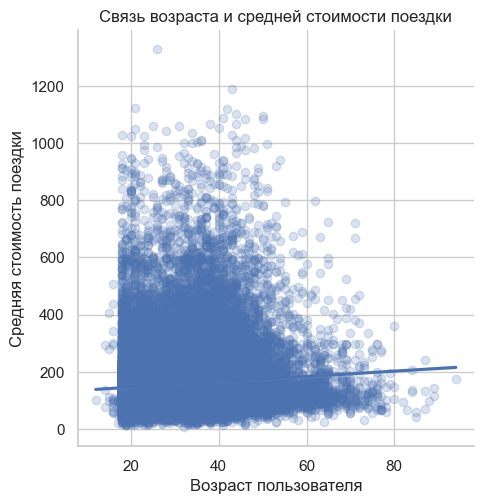

In [14]:
sns.lmplot(data=df_h4, x='age', y='avg_price_per_user', scatter_kws={'alpha':0.2})
plt.title('Связь возраста и средней стоимости поездки')
plt.xlabel('Возраст пользователя')
plt.ylabel('Средняя стоимость поездки')
plt.show()

Pearson r = 0.086 — очень слабая положительная корреляция, Spearman r = 0.106 подтверждает слабую зависимость. Лишь 0.7% изменений стоимости объясняются изменениями возраста (коэффициент детерминации равен 0.007).

Возраст слабо влияет на стоимость поездки: старшие пользователи платят немного больше, но разница не имеет бизнес-значения.

Сегментация по возрасту не нужна — целесообразнее ориентироваться на поведение (частота, регион, длительность поездки).

---
## 4. Вывод
---

Из четырех гипотез три подтвердились статистически, но все различия имеют слабый эффект и низкую значимость. Пол и возраст оказывают незначительное влияние на стоимость и длительность поездки, а активность пользователей остаётся стабильной по дням недели. Следовательно, для бизнеса выгоднее ориентироваться на поведенческие метрики: частоту поездок, среднюю дистанцию, регион и модель самоката.